In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations>=0.3.0
!pip install segmentation-models

In [1]:
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

!git clone https://github.com/invite-you/detectron2 detectron2_repo
!pip install -e detectron2_repo

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.4.0)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.5.0)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.15)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-z7l6gozd
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-z7l6gozd
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-j9bo9uld
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-j9bo9uld
     |████████████████████████████████| 276kB 10.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=41712 sha256=a3f0004b55882681719c8b2b5b0b92be454b44795942ff41e684b2f36ca8c444
  Stored in directory: /tmp/pip-ephem-wheel-cache-o4w2hg7b/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel 

In [3]:
# 인스톨이 완료되면 Colab Runtime을 다시 시작해주세요. 

# 기본 설정
# detectron2 logger 설정
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 자주 사용하는 라이브러리 임폴트
import numpy as np
import cv2
import random
import os
from google.colab.patches import cv2_imshow

import glob
import math

# 자주 사용하는 detectron2 유틸 임폴트 
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

import matplotlib.pyplot as plt
%matplotlib inline


ModuleNotFoundError: ignored

In [4]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

import segmentation_models as sm

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
def predict_TTA(model, image):
    def predict_rotatationt90_image(model, image, times=1):
        image90 = np.rot90(image, times)
        pr_mask = model.predict(np.expand_dims(image90, axis = 0)).squeeze()
        return np.rot90(pr_mask, -times)
    pred_masks = []
    for i in range(1,4):
        pred_masks.append(predict_rotatationt90_image(model, image, times=i))
    
    image_flip = np.flip(image, 0)
    for i in range(1,4):
        pre_mask = predict_rotatationt90_image(model, image_flip, times=i)
        pred_masks.append(np.flip(pre_mask, 0))
    
    pred = np.stack(pred_masks, axis=0).mean(axis=0)
    return pred


def connect_nearby_contours(pred_mask, extend_pixel):
    def find_if_close(cnt1,cnt2):
        row1,row2 = cnt1.shape[0],cnt2.shape[0]
        for i in range(row1):
            for j in range(row2):
                dist = np.linalg.norm(cnt1[i]-cnt2[j])
                if abs(dist) < 50 :
                    return True
                elif i==row1-1 and j==row2-1:
                    return False

    mask = np.argmax(pred_mask, axis = 2) 
    mask_8bit = np.uint8((abs(mask-4)/4) * 255)

    threshold_level = 1 # Set as you need...
    ret, binarized = cv2.threshold(mask_8bit, threshold_level, 255, cv2.THRESH_BINARY)

    # 컨투어 범위 더 넓게
    kernel = np.ones((extend_pixel, extend_pixel),np.uint8)
    binarized = cv2.dilate(binarized, kernel,iterations = 1)

    contours,hier = cv2.findContours(binarized, cv2.RETR_EXTERNAL, 2)
    if 0 == len(contours): return []
    LENGTH = len(contours)
    status = np.zeros((LENGTH,1))

    for i,cnt1 in enumerate(contours):
        x = i    
        if i != LENGTH-1:
            for j,cnt2 in enumerate(contours[i+1:]):
                x = x+1
                dist = find_if_close(cnt1,cnt2)
                if dist == True:
                    val = min(status[i],status[x])
                    status[x] = status[i] = val
                else:
                    if status[x]==status[i]:
                        status[x] = i+1

    unified = []
    maximum = int(status.max())+1
    for i in range(maximum):
        pos = np.where(status==i)[0]
        if pos.size != 0:
            cont = np.vstack(contours[i] for i in pos)
            hull = cv2.convexHull(cont)
            unified.append(hull)
    return unified



def resizeAndPad(img, size, padColor=0):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img


In [1]:
BACKBONE = 'efficientnetb0'
pretrained_weight = '/content/gdrive/My Drive/findShip/models/trainer_UNet_efficientnetb0_CLAHE.h5'

CLASSES = ['container', 'oil tanker', 'aircraft carrier', 'maritime vessels']


n_classes = len(CLASSES) + 1  # case for binary and multiclass segmentation

activation = 'softmax'

model = sm.Unet(BACKBONE, weights=pretrained_weight, classes=n_classes, activation=activation)
preprocess_input = sm.get_preprocessing(BACKBONE)

NameError: ignored

In [0]:
pr_mask.shape

(768, 768, 5)

In [0]:
import albumentations as A

In [0]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.CLAHE(p=1)
    ]
    return A.Compose(test_transform)

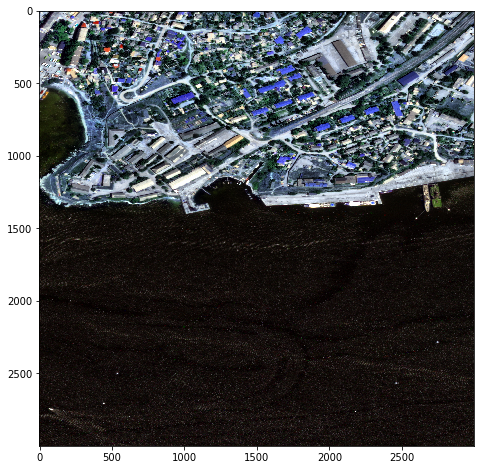

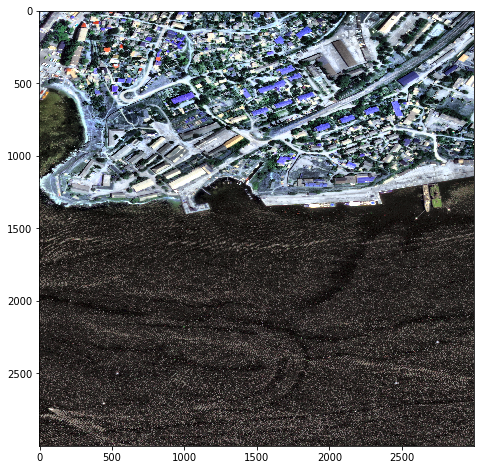

In [23]:
plt.figure(figsize = (8,8))
plt.imshow(img)

i = get_validation_augmentation()(image=img)
plt.figure(figsize = (8,8))
plt.imshow(i['image'])


In [0]:
from tqdm import tqdm
import glob
import math

allpreds={}

image_size = 768
base_path = "/content/gdrive/My Drive/findShip/test_images/*"

path = glob.glob(base_path)
files = [file for file in path if file.endswith(".png")]

count = 0

for file in tqdm(files):
    img = cv2.imread(file)
    #plt.imshow(img, interpolation='nearest')  

    target_image = cv2.resize(img, dsize=(768, 768), interpolation=cv2.INTER_CUBIC)
    print(target_image.shape)

    # For Test
    pre_image = preprocess_input(target_image)
    plt.figure(figsize = (6,8))
    plt.imshow(target_image)

    pr_mask = predict_TTA(model, pre_image)
    print(pr_mask.shape)
    
    mask = np.argmax(pr_mask, axis = 2) 
    mask_8bit = np.uint8((abs(mask-4)/4) * 255)

    threshold_level = 1 # Set as you need...
    ret, binarized = cv2.threshold(mask_8bit, threshold_level, 255, cv2.THRESH_BINARY)

    visualize(
        image=target_image,
        container=pr_mask[..., 0].squeeze(),
        oil_tanker=pr_mask[..., 1].squeeze(),
        aircraft_carrier=pr_mask[..., 2].squeeze(),
        maritime_vessels=pr_mask[..., 3].squeeze(),
        result=binarized,
            )
    
    contours = connect_nearby_contours(pr_mask, 30)

    for contour in contours:
        bbox = cv2.boundingRect(contour)
        x, y, width, height = bbox[0], bbox[1], bbox[2], bbox[3]
        #cv2.rectangle(target_image, (x,y), (x+width, y+height), (255,0,0), 2)

        # MASK cnn에 들어갈 이미지
        target_image = resizeAndPad(target_image[y:y+height , x:x+width, :], (768, 768), 0)
        #target_image = cv2.resize(target_image[y:y+height , x:x+width, :], dsize=(768, 768), interpolation=cv2.INTER_CUBIC)
        plt.figure(figsize = (5,5))
        plt.imshow(target_image)

    count += 1
    if count == 11: break

In [66]:
loopy

4

In [0]:
from tqdm import tqdm
import glob
import math

allpreds={}

image_size = 768
base_path = "/content/gdrive/My Drive/findShip/test_images/*"

path = glob.glob(base_path)
files = [file for file in path if file.endswith(".png")]

count = 0

for file in tqdm(files):
    img = cv2.imread(file)
    #plt.imshow(img, interpolation='nearest')  
    height, width, _ = img.shape

    loopx = math.ceil(width / image_size)
    loopy = math.ceil(height / image_size)

    for x in range(0, loopx):
        minX = image_size * x
        maxX = image_size * (x+1)
        if maxX > width:
            minX = width - image_size
            maxX = width        
        for y in range(0, loopy):
            minY = image_size * y
            maxY = image_size * (y+1)
            if maxY > height:
                minY = height - image_size
                maxY = height

            #plt.figure()
            #plt.imshow(img[minY:maxY, minX:maxX])

            # CSV 만들기 시작
            #outputs = predictor(img[minY:maxY, minX:maxX])
            target_image = img[minY:maxY, minX:maxX]
            print(target_image.shape)

            # For Test
            pre_image = preprocess_input(target_image)
            plt.figure(figsize = (8,8))
            plt.imshow(target_image)

            pr_mask = predict_TTA(model, pre_image)
            print(pr_mask.shape)
            
            mask = np.argmax(pr_mask, axis = 2) 
            mask_8bit = np.uint8((abs(mask-4)/4) * 255)

            threshold_level = 1 # Set as you need...
            ret, binarized = cv2.threshold(mask_8bit, threshold_level, 255, cv2.THRESH_BINARY)

            visualize(
                image=target_image,
                container=pr_mask[..., 0].squeeze(),
                oil_tanker=pr_mask[..., 1].squeeze(),
                aircraft_carrier=pr_mask[..., 2].squeeze(),
                maritime_vessels=pr_mask[..., 3].squeeze(),
                result=binarized,
                    )

            contours = connect_nearby_contours(pr_mask, 30)

            for contour in contours:
                bbox = cv2.boundingRect(contour)
                x, y, cwidth, cheight = bbox[0], bbox[1], bbox[2], bbox[3]
                cv2.rectangle(target_image, (x,y), (x+cwidth, y+cheight), (255,0,0), 2)

                # MASK cnn에 들어갈 이미지
                ctarget_image = cv2.resize(target_image[y:y+cheight , x:x+cwidth, :], dsize=(768, 768), interpolation=cv2.INTER_CUBIC)
                plt.figure(figsize = (8,8))
                plt.imshow(ctarget_image)
                
    count += 1
    if count == 4: break

In [0]:
#image_file = r'/content/gdrive/My Drive/findShip/custom_coco_/train2017/2728_1536_1024.png'
#image_file = r'/content/gdrive/My Drive/findShip/custom_coco_/train2017/27_2048_1024.png'
image_file = r'/content/gdrive/My Drive/findShip/custom_coco_/train2017/3_1536_2048.png'
image = cv2.imread(image_file)

print(image.shape)

pre_image = preprocess_input(image)
plt.figure(figsize = (8,8))
plt.imshow(pre_image)

pr_mask = predict_TTA(model, pre_image)
print(pr_mask.shape)

visualize(
    image=image,
    container=pr_mask[..., 0].squeeze(),
    oil_tanker=pr_mask[..., 1].squeeze(),
    aircraft_carrier=pr_mask[..., 2].squeeze(),
    maritime_vessels=pr_mask[..., 3].squeeze(),
        )

In [8]:
from keras import backend as K
K.clear_session()

In [0]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

base_dir = r"/content/gdrive/My Drive/findShip/custom_coco/"

pretrained_model = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file( pretrained_model)
)
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(pretrained_model)
cfg.MODEL.WEIGHTS = os.path.join(base_dir, 'models', 'mask_rcnn_R_101_FPN_3x_frezzereal-1', "model_0057999.pth")
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "last_checkpoint")

cfg.MODEL.BACKBONE.FREEZE_AT = 0

cfg.INPUT.CROP.ENABLED = True

cfg.INPUT.MAX_SIZE_TEST = 1024
cfg.INPUT.MAX_SIZE_TRAIN = 1024
cfg.INPUT.MIN_SIZE_TEST = 1024
cfg.INPUT.MIN_SIZE_TRAIN = (1024,)

cfg.DATALOADER.REPEAT_THRESHOLD = 1.0

cfg.MODEL.RPN.NMS_THRESH = 0.3
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.3
cfg.MODEL.RETINANET.NMS_THRESH_TEST = 0.3

cfg.MODEL.ANCHOR_GENERATOR.ANGLES: [[-15, -30, -45, -60, -75, -90, -105, -120, -135, -150, -165, -180, -270, -285, -300, -315, -330, -345, 0, 15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180, 270, 285, 300, 315, 330, 345]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]]
#cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32], [64], [128], [256], [512], [1000]]

cfg.SOLVER.IMS_PER_BATCH = 5
cfg.SOLVER.BASE_LR = 0.02#0.2
cfg.SOLVER.MAX_ITER = 39000    # 300 iterations seems good enough, but you can certainly train longer
cfg.SOLVER.STEPS = (30000,)
cfg.SOLVER.GAMMA = 0.05#0.5
cfg.SOLVER.MOMENTUM = 0.05#0.09#0.9
cfg.SOLVER.CHECKPOINT_PERIOD = 2000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 1024   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # only has one class (ballon)

"""
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = DefaultTrainer(cfg) 
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()
"""

# Create predictor
predictor = DefaultPredictor(cfg)

In [0]:
contours = connect_nearby_contours(pr_mask, 30)


for contour in contours:
    bbox = cv2.boundingRect(contour)
    x, y, width, height = bbox[0], bbox[1], bbox[2], bbox[3]
    cv2.rectangle(image, (x,y), (x+width, y+height), (255,0,0), 2)

    # MASK cnn에 들어갈 이미지
    target_image = cv2.resize(image[y:y+height , x:x+width, :], dsize=(768, 768), interpolation=cv2.INTER_CUBIC)
    
    outputs = predictor(target_image)
    print(outputs)
    v = Visualizer(target_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.3)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (20,20))
    plt.imshow(v.get_image()[:, :, ::-1])

    plt.figure(figsize = (8,8))
    plt.imshow(target_image)


In [0]:
image_file = r'/content/gdrive/My Drive/findShip/custom_coco_/train2017/3_1536_2048.png'
image = cv2.imread(image_file)
image_w, image_h = image.shape

margin = 0.1

for contour in contours:
    bbox = cv2.boundingRect(contour)
    x = bbox[0]
    y = bbox[1]
    width = bbox[2]
    height = bbox[3]
    print(bbox)
    # 마진 추가 (타겟이미지의 일부만 ))))
    w_margin = (width * margin) / 2

    x1 = x-w_margin
    x2 = x+width+w_margin
    
    y1 = 
    if image_w > x2: x2 = image_w
    if 0 > x1: x1 = 0

    plt.figure(figsize = (8,8))
    plt.imshow(image[y:y+height , x-w_margin:x+width+w_margin, :])


(48, 597, 97, 42)


TypeError: ignored

<Figure size 576x576 with 0 Axes>

In [0]:
len(contours)

7

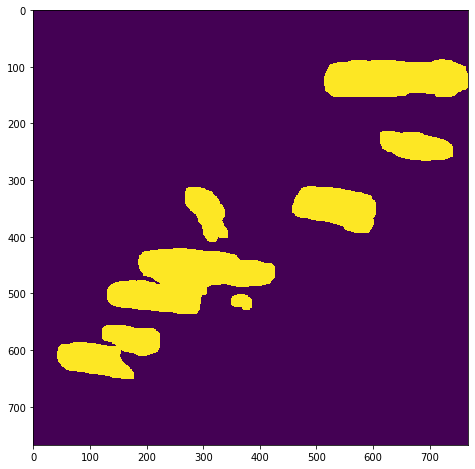

In [0]:
plt.figure(figsize = (8,8))
plt.imshow(binarized)


In [0]:
image_file = '/content/gdrive/My Drive/findShip/custom_coco_/train2017/3_1536_2048.png'
img = cv2.imread(image_file)
# Make prediction

img90 = np.rot90(img,3)

plt.figure(figsize = (8,8))
plt.imshow(img)
plt.figure(figsize = (8,8))
plt.imshow(img90)

img90 = np.rot90(img90,-3)

plt.figure(figsize = (8,8))
plt.imshow(img90)


KeyboardInterrupt: ignored

In [0]:
image = cv2.imread(image_file)
image = np.flip(image, 0)
plt.figure(figsize = (8,8))
plt.imshow(image)

image = np.flip(image, 0)
plt.figure(figsize = (8,8))
plt.imshow(image)

image = np.flip(image, 0)
plt.figure(figsize = (8,8))
plt.imshow(image)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


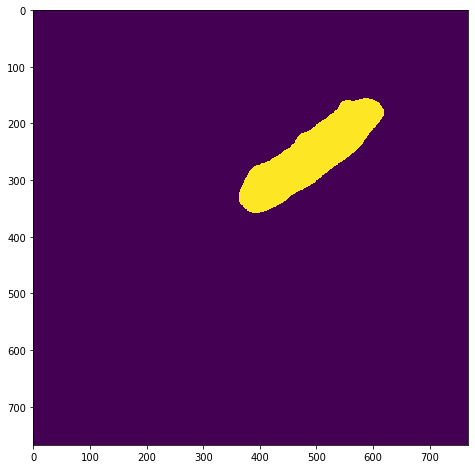

<Figure size 576x576 with 0 Axes>

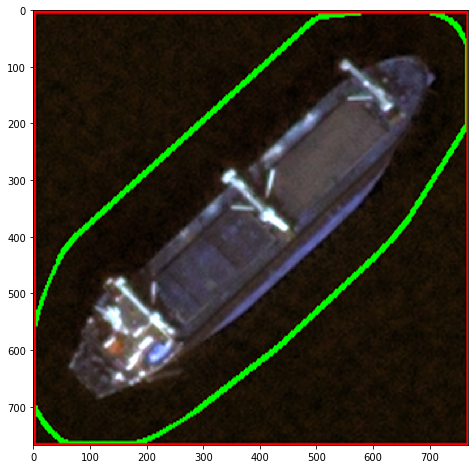

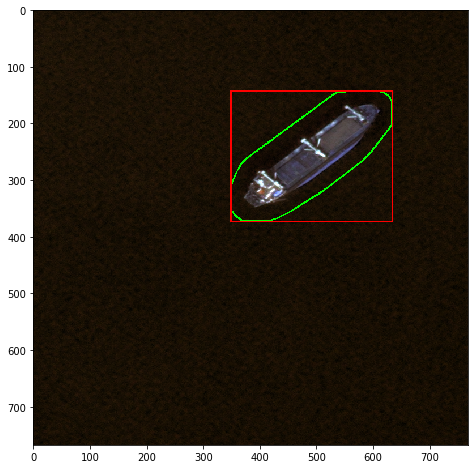

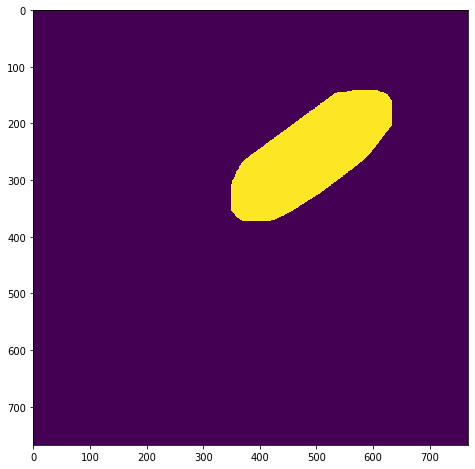

In [0]:

def find_if_close(cnt1,cnt2):
    row1,row2 = cnt1.shape[0],cnt2.shape[0]
    for i in range(row1):
        for j in range(row2):
            dist = np.linalg.norm(cnt1[i]-cnt2[j])
            if abs(dist) < 50 :
                return True
            elif i==row1-1 and j==row2-1:
                return False

#image_file = r'/content/gdrive/My Drive/findShip/custom_coco_/train2017/3_1536_2048.png'
#img = cv2.imread(image_file)


pr_mask.shape
mask = np.argmax(pr_mask, axis = 2) 
mask.shape

mask_8bit = np.uint8((abs(mask-4)/4) * 255)

threshold_level = 1 # Set as you need...
ret, binarized = cv2.threshold(mask_8bit, threshold_level, 255, cv2.THRESH_BINARY)


plt.figure(figsize = (8,8))
plt.imshow(binarized)

# 컨투어 범위 더 넓게
kernel = np.ones((30,30),np.uint8)
binarized = cv2.dilate(binarized, kernel,iterations = 1)

contours,hier = cv2.findContours(binarized, cv2.RETR_EXTERNAL, 2)

LENGTH = len(contours)
status = np.zeros((LENGTH,1))

for i,cnt1 in enumerate(contours):
    x = i    
    if i != LENGTH-1:
        for j,cnt2 in enumerate(contours[i+1:]):
            x = x+1
            dist = find_if_close(cnt1,cnt2)
            if dist == True:
                val = min(status[i],status[x])
                status[x] = status[i] = val
            else:
                if status[x]==status[i]:
                    status[x] = i+1

unified = []
maximum = int(status.max())+1
for i in range(maximum):
    pos = np.where(status==i)[0]
    if pos.size != 0:
        cont = np.vstack(contours[i] for i in pos)
        hull = cv2.convexHull(cont)
        unified.append(hull)

cv2.drawContours(image, unified,-1,(0,255,0),2)
cv2.drawContours(binarized, unified,-1,255,-1)

for contour in unified:
    bbox = cv2.boundingRect(contour)
    x, y, width, height = bbox[0], bbox[1], bbox[2], bbox[3]
    cv2.rectangle(image, (x,y), (x+width, y+height), (255,0,0), 2)

    plt.figure(figsize = (8,8))
    # MASK cnn에 들어갈 이미지
    target_image = cv2.resize(image[y:y+height , x:x+width, :], dsize=(768, 768), interpolation=cv2.INTER_CUBIC)
    plt.figure(figsize = (8,8))
    plt.imshow(target_image)


plt.figure(figsize = (8,8))
plt.imshow(image)

plt.figure(figsize = (8,8))
plt.imshow(binarized)

In [0]:
# 디버그용으로 남겨둠

pr_mask.shape
mask = np.argmax(pr_mask, axis = 2) 
mask.shape

mask_8bit = np.uint8((abs(mask-4)/4) * 255)
threshold_level = 1 # Set as you need...
_, binarized = cv2.threshold(mask_8bit, threshold_level, 255, cv2.THRESH_BINARY)

# 컨투어 범위 더 넓게
kernel = np.ones((10,10),np.uint8)
binarized = cv2.dilate(binarized, kernel,iterations = 1)

contours, _ = cv2.findContours(binarized, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [4]:
import os
from pycocotools.coco import COCO

base_dir = r"/content/gdrive/My Drive/findShip/custom_coco_/"
# TODO: 전체 테스트셋을 하나의 파일로 만들기
annt_file = os.path.join(base_dir, 'annotations', "instances_train2017.json")
image_dir = os.path.join(base_dir, 'train2017')


coco = COCO(annt_file)
len(coco.anns)

loading annotations into memory...
Done (t=1.95s)
creating index...
index created!


31826

In [5]:
dir(coco)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'annToMask',
 'annToRLE',
 'anns',
 'catToImgs',
 'cats',
 'createIndex',
 'dataset',
 'download',
 'getAnnIds',
 'getCatIds',
 'getImgIds',
 'imgToAnns',
 'imgs',
 'info',
 'loadAnns',
 'loadCats',
 'loadImgs',
 'loadNumpyAnnotations',
 'loadRes',
 'showAnns']